# Text classification with an RNN

## Setup

In [1]:
import pandas as pd
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])



# Get Datasets and Dataframes

In [3]:
testingDatasets = []
trainingDatasets = []

for i in range(2):
  testingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/test/dialogues_00' + str(i+1) + '.json'))

for i in range(9):
  trainingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_00' + str(i+1) + '.json'))

for i in range(8):
  trainingDatasets.append(pd.read_json('https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_0' + str(i+10) + '.json'))

testingDatasets = pd.concat([testingDatasets[0], testingDatasets[1]])
trainingDatasets = pd.concat([trainingDatasets[0], trainingDatasets[1],trainingDatasets[2],trainingDatasets[3],trainingDatasets[4],trainingDatasets[5],trainingDatasets[6],trainingDatasets[7],trainingDatasets[8],trainingDatasets[9],trainingDatasets[10],trainingDatasets[11],trainingDatasets[12],trainingDatasets[13],trainingDatasets[14],trainingDatasets[15],trainingDatasets[16]])
testingDatasets

,dialogue_id,services,turns
0,MUL0484.json,"[attraction, train]","[{'frames': [{'actions': [], 'service': 'train..."
1,PMUL4462.json,"[restaurant, taxi, attraction]","[{'frames': [{'actions': [], 'service': 'resta..."
2,PMUL0320.json,"[restaurant, taxi, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
3,MUL2155.json,"[train, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
4,PMUL0815.json,"[restaurant, train]","[{'frames': [{'actions': [], 'service': 'resta..."
...,...,...,...
483,MUL0306.json,"[restaurant, train]","[{'frames': [{'actions': [], 'service': 'train..."
484,MUL2228.json,"[train, hotel]","[{'frames': [{'actions': [], 'service': 'train..."
485,MUL0641.json,"[train, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
486,PMUL1194.json,"[attraction, train]","[{'frames': [{'actions': [], 'service': 'attra..."


In [4]:
trainingDatasets

,dialogue_id,services,turns
0,PMUL4398.json,"[restaurant, hotel]","[{'frames': [{'actions': [], 'service': 'resta..."
1,SNG1013.json,[hotel],"[{'frames': [{'actions': [], 'service': 'hotel..."
2,PMUL0121.json,"[restaurant, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
3,PMUL3484.json,"[restaurant, taxi, hotel]","[{'frames': [{'actions': [], 'service': 'hotel..."
4,SNG0389.json,[train],"[{'frames': [{'actions': [], 'service': 'train..."
...,...,...,...
241,SNG1123.json,[attraction],"[{'frames': [{'actions': [], 'service': 'attra..."
242,SNG0925.json,[hotel],"[{'frames': [{'actions': [], 'service': 'hotel..."
243,MUL1853.json,"[attraction, train]","[{'frames': [{'actions': [], 'service': 'train..."
244,WOZ20361.json,[restaurant],"[{'frames': [{'actions': [], 'service': 'resta..."


In [5]:
# seleciona no json os campos relevantes. Apenas as falas dos usuários (ignora os do System)
def getDataframes(dataframe):
  entries_classifier = []
  entries_extractor = []

  for turn in dataframe['turns']:
    for entry in turn:
      if entry['speaker'] == 'USER':
        intent = ''
        slot_values = []
        requested_slots = []
        phrase = entry['utterance']
        for frame in entry['frames']:  
          if frame['state']['active_intent'] != 'NONE':
            intent = frame['state']['active_intent']
            slot_values = frame['state']['slot_values']
            requested_slots = frame['state']['requested_slots']
        entries_classifier.append({'entry': phrase, 'intent': intent})
        entries_extractor.append({'entry': phrase, 'intent': intent, 'slot_values': slot_values, 'requested_slots': requested_slots})

  classifier = pd.DataFrame.from_dict(entries_classifier)
  extractor = pd.DataFrame.from_dict(entries_extractor)

  return classifier, extractor

test_classifier, test_extractor = getDataframes(testingDatasets)
train_classifier, train_extractor = getDataframes(trainingDatasets)

test_classifier

,entry,intent
0,I need train reservations from norwich to camb...,find_train
1,I'd like to leave on Monday and arrive by 18:00.,find_train
2,"Before booking, I would also like to know the ...",find_train
3,No hold off on booking for now. Can you help m...,find_attraction
4,"Yes, that was all I needed. Thank you very much!",
...,...,...
7367,"A swimming pool sounds like much more fun, doe...",find_attraction
7368,Any one of those is fine. May I get the entran...,find_attraction
7369,"Yes. I am also looking for a train, leaving on...",find_train
7370,That will work. Can I have this booking for si...,book_train


In [6]:
trainingDatasets['turns']

0      [{'frames': [{'actions': [], 'service': 'resta...
1      [{'frames': [{'actions': [], 'service': 'hotel...
2      [{'frames': [{'actions': [], 'service': 'hotel...
3      [{'frames': [{'actions': [], 'service': 'hotel...
4      [{'frames': [{'actions': [], 'service': 'train...
                             ...                        
241    [{'frames': [{'actions': [], 'service': 'attra...
242    [{'frames': [{'actions': [], 'service': 'hotel...
243    [{'frames': [{'actions': [], 'service': 'train...
244    [{'frames': [{'actions': [], 'service': 'resta...
245    [{'frames': [{'actions': [], 'service': 'resta...
Name: turns, Length: 8437, dtype: object

# Classify Intents


## Recognize intents from other domains/services

In [7]:
# aqueles intents que não interessam ao projeto são marcados como "Invalid"
def recognizeIntents(intent):
  if (intent == 'find_restaurant' or intent == 'book_restaurant'):
    return intent
  return 'Invalid'

train_classifier['intent'] = train_classifier['intent'].apply(recognizeIntents)
test_classifier['intent'] = test_classifier['intent'].apply(recognizeIntents)
train_extractor['intent'] = train_extractor['intent'].apply(recognizeIntents)
test_extractor['intent'] = test_extractor['intent'].apply(recognizeIntents)
train_classifier['intent'].unique()


array(['Invalid', 'find_restaurant', 'book_restaurant'], dtype=object)

In [8]:
train_classifier['intent'].head(16)

0             Invalid
1             Invalid
2             Invalid
3             Invalid
4             Invalid
5             Invalid
6             Invalid
7     find_restaurant
8     find_restaurant
9             Invalid
10            Invalid
11            Invalid
12            Invalid
13            Invalid
14            Invalid
15    find_restaurant
Name: intent, dtype: object

In [9]:
train_classifier['intent'].unique()

array(['Invalid', 'find_restaurant', 'book_restaurant'], dtype=object)

## Create categories for intents


In [10]:
# transforma as strings categóricas em números, permitindo processar melhor
train_classifier['intent'] = pd.Categorical(train_classifier['intent'])
train_classifier['intent'] = train_classifier.intent.cat.codes
train_classifier['intent'].unique()

array([0, 2, 1], dtype=int8)

In [11]:
test_classifier['intent'] = pd.Categorical(test_classifier['intent'])
test_classifier['intent'] = test_classifier.intent.cat.codes
test_classifier['intent'].unique()

array([0, 2, 1], dtype=int8)

## Setup input pipeline


In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_classifier['entry'], train_classifier['intent']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_classifier['entry'], test_classifier['intent']))
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'i need a place to dine in the center thats expensive'
label:  0


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [14]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
# agora, ele já está com a batch de 64 entradas
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'An art museum near the restaurant sounds nice. How much is the admission price?'
 b'have you heard of cote? its a restaurant in town'
 b'I would like Italian food, if possible.'
 b"That sounds perfect, thanks. Can you also help me find a guesthouse to stay in? I'd like a 4 star location, please."
 b"Yes, I'm looking for a steakhouse restaurant in the expensive price range."
 b'Does that have a 5 star rating?' b'Do you have the phone number there?'
 b'Yes, I would like to book a train that will arrive in Ely before 11:30.'
 b'Well, I guess I forgot to specify that I need something on the south end of town.'
 b'Ok, thank you for the help.'
 b'Yes, can you also help me find a train leaving on Saturday after 15:15?'
 b'I need the contact number please.' b"No, that's everything I needed."
 b"no thanks that's all" b"No, I don't need a reservation."
 b'No, I would like it for 4 people.' b'I want it to arrive by 18:00'
 b'I do not care.' b'Can I get the postcode please?'
 b'Thank you

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [16]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
# pegando nossos textos e criando o vocabulário
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [17]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'the', 'a', 'to', 'for', 'you', 'need', 'that',
       'and', 'in', 'please', 'can', 'me', 'is', 'thank', 'on', 'yes',
       'looking'], dtype='<U16')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [18]:
# pegamos primeiros três de "example", textos extraídos do train_dataset, para servir de exemplo
# Cada palavra recebe um valor numérico, que pode ser reconvertido em palavras
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 89, 482, 163, 284,   3,  29, 103, 210,  90,  79,  15,   3, 744,
         49,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 31,   7, 487,  22,   1, 194,   4,  29,  11,  53,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  23,  21, 209,  58, 105, 269,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [19]:
# como se pode ver, cada número representa uma palavra
example.numpy()[:3]

array([b'An art museum near the restaurant sounds nice. How much is the admission price?',
       b'have you heard of cote? its a restaurant in town',
       b'I would like Italian food, if possible.'], dtype=object)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [20]:
# em vocab[encoded_example[n]]), passamos o valor numérico
# de cada palavra, que é mapeado em vocab
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'An art museum near the restaurant sounds nice. How much is the admission price?'
Round-trip:  an art museum near the restaurant sounds nice how much is the admission price         

Original:  b'have you heard of cote? its a restaurant in town'
Round-trip:  have you heard of [UNK] its a restaurant in town             

Original:  b'I would like Italian food, if possible.'
Round-trip:  i would like italian food if possible                



## Create the model

The code to implement this is below:

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 138,499
Trainable params: 138,499
Non-trai

Compile the Keras model to configure the training process:

In [22]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=["mae", "acc"]
              )

## Train the model

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/6
888/888 [==============================] - 42s 34ms/step - loss: 0.3697 - mae: 0.5690 - acc: 0.8669 - val_loss: 0.3066 - val_mae: 0.5245 - val_acc: 0.8865
Epoch 2/6
888/888 [==============================] - 27s 31ms/step - loss: 0.3069 - mae: 0.5690 - acc: 0.8817 - val_loss: 0.2826 - val_mae: 0.5245 - val_acc: 0.8964
Epoch 3/6
888/888 [==============================] - 28s 31ms/step - loss: 0.2908 - mae: 0.5690 - acc: 0.8873 - val_loss: 0.2775 - val_mae: 0.5245 - val_acc: 0.8974
Epoch 4/6
888/888 [==============================] - 28s 31ms/step - loss: 0.2799 - mae: 0.5690 - acc: 0.8902 - val_loss: 0.2801 - val_mae: 0.5245 - val_acc: 0.9005
Epoch 5/6
888/888 [==============================] - 28s 31ms/step - loss: 0.2701 - mae: 0.5690 - acc: 0.8932 - val_loss: 0.2767 - val_mae: 0.5245 - val_acc: 0.8984
Epoch 6/6
888/888 [==============================] - 28s 31ms/step - loss: 0.2621 - mae: 0.5690 - acc: 0.8959 - val_loss: 0.2787 - val_mae: 0.5245 - val_acc: 0.8922


In [26]:
test_loss, test_acc, *is_anything_else_being_returned = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

888/888 [==============================] - 11s 12ms/step - loss: 0.2472 - mae: 0.5690 - acc: 0.9014
Test Loss: 0.24718961119651794
Test Accuracy: 0.5689960718154907


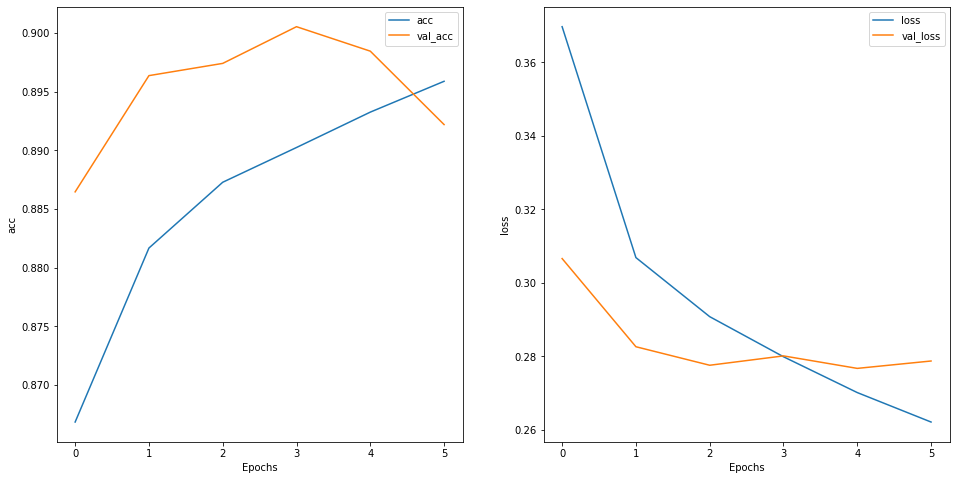

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'acc')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [37]:
predictions = model.predict(['I would like me something to eat'])
c = np.array(['Invalid', 'find_restaurant', 'book_restaurant'])
print(predictions[0])
print(c[np.argmax(predictions[0])])

[1.4664056e-03 5.5676262e-04 9.9797684e-01]
book_restaurant


# Extract entities


In [38]:
train_extractor

,entry,intent,slot_values,requested_slots
0,i need a place to dine in the center thats exp...,Invalid,{},[]
1,"Any sort of food would be fine, as long as it ...",Invalid,{},[]
2,"Sounds good, could I get that phone number? Al...",Invalid,"{'hotel-pricerange': ['expensive'], 'hotel-typ...",[]
3,Yes. Can you book it for me?,Invalid,"{'hotel-name': ['university arms hotel'], 'hot...",[]
4,i want to book it for 2 people and 2 nights st...,Invalid,"{'hotel-bookday': ['saturday'], 'hotel-bookpeo...",[]
...,...,...,...,...
56771,"Hello, I am looking for a cheap restaurant tha...",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pr...",[]
56772,"Yes, how about portuguese food?",find_restaurant,"{'restaurant-food': ['portuguese'], 'restauran...",[]
56773,It doesn't matter.,find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-...",[]
56774,"I would like the address of Nandos restaurant,...",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-...",[restaurant-address]


In [40]:
train_extractor['entry'] = train_extractor['entry'].apply(lambda x: x.lower().replace('.','').replace(',','').replace(':','').replace(';','').replace('!','').replace('?','').replace('\'',''))
train_extractor['entry'].head(10)

0    i need a place to dine in the center thats exp...
1    any sort of food would be fine as long as it i...
2    sounds good could i get that phone number also...
3                           yes can you book it for me
4    i want to book it for 2 people and 2 nights st...
5           that is all i need to know thanks good bye
6    guten tag i am staying overnight in cambridge ...
7    no but id really like to be on the south end o...
8    no i dont care about the price which one do yo...
9    yes book it for 4 people and 4 nights starting...
Name: entry, dtype: object

In [41]:
train_extractor['entry'] = train_extractor['entry'].apply(lambda x : x.split())
train_extractor['entry']

0        [i, need, a, place, to, dine, in, the, center,...
1        [any, sort, of, food, would, be, fine, as, lon...
2        [sounds, good, could, i, get, that, phone, num...
3                       [yes, can, you, book, it, for, me]
4        [i, want, to, book, it, for, 2, people, and, 2...
                               ...                        
56771    [hello, i, am, looking, for, a, cheap, restaur...
56772                  [yes, how, about, portuguese, food]
56773                                 [it, doesnt, matter]
56774    [i, would, like, the, address, of, nandos, res...
56775                                [thank, you, goodbye]
Name: entry, Length: 56776, dtype: object

In [42]:
train_extractor = train_extractor[train_extractor['intent']!='Invalid']
test_extractor = test_extractor[test_extractor['intent']!='Invalid']
train_extractor

,entry,intent,slot_values,requested_slots
7,"[no, but, id, really, like, to, be, on, the, s...",find_restaurant,{},[]
8,"[no, i, dont, care, about, the, price, which, ...",find_restaurant,{},[]
15,"[yeah, i, need, a, restaurant, in, the, west, ...",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pric...",[]
16,"[no, i, dont, have, a, preference, but, i, nee...",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pric...","[restaurant-phone, restaurant-postcode]"
24,"[can, you, actually, look, up, a, restaurant, ...",find_restaurant,{},[]
...,...,...,...,...
56769,"[what, is, there, phone, number]",find_restaurant,"{'restaurant-area': ['east'], 'restaurant-food...",[restaurant-phone]
56771,"[hello, i, am, looking, for, a, cheap, restaur...",find_restaurant,"{'restaurant-food': ['german'], 'restaurant-pr...",[]
56772,"[yes, how, about, portuguese, food]",find_restaurant,"{'restaurant-food': ['portuguese'], 'restauran...",[]
56773,"[it, doesnt, matter]",find_restaurant,"{'restaurant-area': ['dontcare'], 'restaurant-...",[]


In [75]:
pd.set_option('display.max_colwidth', None) 
train_extractor.head(20)

,entry,intent,slot_values,requested_slots,tags
7,"[no, but, id, really, like, to, be, on, the, south, end, of, the, city, do, any, of, those, fit, the, bill]",find_restaurant,{},[],None
8,"[no, i, dont, care, about, the, price, which, one, do, you, recommend]",find_restaurant,{},[],None
15,"[yeah, i, need, a, restaurant, in, the, west, and, with, expensive, pricing]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}",[],None
16,"[no, i, dont, have, a, preference, but, i, need, the, phone, number, and, postcode]",find_restaurant,"{'restaurant-area': ['west'], 'restaurant-pricerange': ['expensive']}","[restaurant-phone, restaurant-postcode]",None
24,"[can, you, actually, look, up, a, restaurant, for, me, as, well]",find_restaurant,{},[],None
25,"[its, a, place, called, don, pasquale, pizzeria]",find_restaurant,{'restaurant-name': ['don pasquale pizzeria']},[],None
38,"[i, am, looking, for, a, restaurant, i, would, like, something, cheap, that, has, chinese, food]",find_restaurant,"{'restaurant-food': ['chinese'], 'restaurant-pricerange': ['cheap']}",[],None
39,"[yes, could, you, make, a, reservation, for, 1, at, 2000, on, saturday]",book_restaurant,"{'restaurant-bookday': ['saturday'], 'restaurant-bookpeople': ['1'], 'restaurant-booktime': ['20:00'], 'restaurant-food': ['chinese'], 'restaurant-name': ['the lucky star'], 'restaurant-pricerange': ['cheap']}",[],None
43,"[saturday, leaving, cambridge, anytime, after, 2000, please]",find_restaurant,{},[],None
45,"[i, am, also, looking, for, the, riverside, brasserie]",find_restaurant,{'restaurant-name': ['riverside brasserie']},[],None


In [100]:
# "restaurant-area",
# "restaurant-bookday",
# "restaurant-bookpeople",
# "restaurant-booktime",
# "restaurant-food",
# "restaurant-name",
# "restaurant-pricerange",
def get_slots(te):

  tags = []

  for i, row in te.iterrows():
    t = []
    for w in row['entry']:
      ap = 'O'
      for j in row['slot_values']:
        if w == row['slot_values'][j][0]:
          ap = w
      t.append(ap)
    tags.append(t)
  
  return tags

train_extractor['tags'] = get_slots(train_extractor)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [101]:
train_extractor.head(30)

7                        [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
8                                                   [O, O, O, O, O, O, O, O, O, O, O, O]
15                                       [O, O, O, O, O, O, O, west, O, O, expensive, O]
16                                            [O, O, O, O, O, O, O, O, O, O, O, O, O, O]
24                                                     [O, O, O, O, O, O, O, O, O, O, O]
25                                                                 [O, O, O, O, O, O, O]
38                               [O, O, O, O, O, O, O, O, O, O, cheap, O, O, chinese, O]
39                                           [O, O, O, O, O, O, O, 1, O, O, O, saturday]
43                                                                 [O, O, O, O, O, O, O]
45                                                              [O, O, O, O, O, O, O, O]
46                                                  [O, O, O, O, O, O, O, O, O, O, O, O]
48                   